# Predicting maimai DX player map achievement scores

In [1356]:
# pip install ipykernel ipympl jupyter matplotlib numpy pandas scikit-learn seaborn
# or: uv sync

In [1357]:
RANDOM_STATE = None

In [1358]:
%matplotlib inline
from pathlib import Path

import rich
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNetCV, RidgeCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    PolynomialFeatures,
    RobustScaler,
)

pd.set_option("display.max_columns", None)

In [1359]:
# Loading the data
maimai_path = Path("maimai.csv")
bpm_path = Path("bpm.csv")

maimai_df = pd.read_csv(maimai_path)
bpm_df = pd.read_csv(bpm_path)

In [1360]:
maimai_df

,Song,Genre,Version,Chart,Difficulty,Level,Achv,Rank,FC/AP,Sync,DX ✦,DX %,DX Score,Chart Constant
0,躯樹の墓守,maimai,UNiVERSE,DX,BASIC,6,94.23%,AAA,FC,SYNC,0,75.40%,570/756,?
1,系ぎて,maimai,BUDDiES,DX,BASIC,7,96.63%,AAA,-,SYNC,0,74.20%,766/1032,?
2,INTERNET YAMERO,POPS＆ANIME,BUDDiES PLUS,DX,ADVANCED,7+,96.34%,AAA,-,SYNC,0,73.20%,854/1167,7.8
3,INTERNET OVERDOSE,POPS＆ANIME,FESTiVAL,DX,ADVANCED,7,96.11%,AAA,-,SYNC,0,76.80%,820/1068,7.5
4,廻廻奇譚,POPS＆ANIME,UNiVERSE,DX,ADVANCED,7,97.65%,S,-,SYNC,0,79.00%,886/1122,7.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,Sweets×Sweets,maimai,maimai,STD,MASTER,11,96.53%,AAA,-,-,0,79.20%,920/1161,11.4
431,ネコ日和。,maimai,maimai,STD,MASTER,12+,96.58%,AAA,-,-,0,78.20%,812/1038,12.6
432,STARTLINER,オンゲキ＆CHUNITHM,maimaiでらっくす,DX,MASTER,11+,98.54%,S+,-,SYNC,1,86.80%,1356/1563,11.8
433,STARRED HEART,オンゲキ＆CHUNITHM,FESTiVAL PLUS,DX,MASTER,12,91.32%,AA,-,SYNC,0,77.00%,1114/1446,12.5


In [1361]:
bpm_df

,songId,bpm,releaseDate
0,"""411Ψ892""",184.0,2023-02-03
1,#狂った民族２ PRAVARGYAZOOQA,170.0,2022-11-18
2,+♂,180.0,2015-12-09
3,-OutsideR:RequieM-,181.0,2019-03-08
4,1000年生きてる,100.0,2023-09-14
...,...,...,...
1346,頓珍漢の宴,145.0,2016-04-07
1347,天火明命,155.0,2017-05-23
1348,ミラクルポップ☆アドベンチャー!!!!!,180.0,2024-07-05
1349,フォルテシモBELL,121.0,2017-02-07


In [1362]:
# Merging datasets
maimai_df.rename(columns={"Song": "songId"}, inplace=True)
merged_df = maimai_df.merge(bpm_df, on="songId", how="left")
print(f"Duplicated: {merged_df.duplicated().sum()}")
merged_df.head()

Duplicated: 0


,songId,Genre,Version,Chart,Difficulty,Level,Achv,Rank,FC/AP,Sync,DX ✦,DX %,DX Score,Chart Constant,bpm,releaseDate
0,躯樹の墓守,maimai,UNiVERSE,DX,BASIC,6,94.23%,AAA,FC,SYNC,0,75.40%,570/756,?,211.0,2022-02-10
1,系ぎて,maimai,BUDDiES,DX,BASIC,7,96.63%,AAA,-,SYNC,0,74.20%,766/1032,?,88.0,2024-02-29
2,INTERNET YAMERO,POPS＆ANIME,BUDDiES PLUS,DX,ADVANCED,7+,96.34%,AAA,-,SYNC,0,73.20%,854/1167,7.8,185.0,2024-03-21
3,INTERNET OVERDOSE,POPS＆ANIME,FESTiVAL,DX,ADVANCED,7,96.11%,AAA,-,SYNC,0,76.80%,820/1068,7.5,163.0,2023-03-23
4,廻廻奇譚,POPS＆ANIME,UNiVERSE,DX,ADVANCED,7,97.65%,S,-,SYNC,0,79.00%,886/1122,7.5,185.0,2021-09-16


In [1363]:
# Clean up unnecessary columns
merged_df.drop(columns=["FC/AP", "Sync", "DX ✦", "DX %"], inplace=True)

# Expose missing values
merged_df["Chart Constant"] = pd.to_numeric(
    merged_df["Chart Constant"], errors="coerce"
)

In [1364]:
# convert releaseDate to numerical values
merged_df["releaseDate"] = pd.to_datetime(merged_df["releaseDate"], errors="coerce")
merged_df["releaseDate"] = (
    merged_df["releaseDate"] - merged_df["releaseDate"].min()
).dt.days
merged_df.head(3)

,songId,Genre,Version,Chart,Difficulty,Level,Achv,Rank,DX Score,Chart Constant,bpm,releaseDate
0,躯樹の墓守,maimai,UNiVERSE,DX,BASIC,6,94.23%,AAA,570/756,NaN,211.0,3501.0
1,系ぎて,maimai,BUDDiES,DX,BASIC,7,96.63%,AAA,766/1032,NaN,88.0,4250.0
2,INTERNET YAMERO,POPS＆ANIME,BUDDiES PLUS,DX,ADVANCED,7+,96.34%,AAA,854/1167,7.8,185.0,4271.0


In [1365]:
print(f"\nTotal rows with missing values: {merged_df.isna().any(axis=1).sum()}")
print("Rows with missing values:")
merged_df[merged_df.isna().any(axis=1)]


Total rows with missing values: 11
Rows with missing values:


,songId,Genre,Version,Chart,Difficulty,Level,Achv,Rank,DX Score,Chart Constant,bpm,releaseDate
0,躯樹の墓守,maimai,UNiVERSE,DX,BASIC,6,94.23%,AAA,570/756,NaN,211.0,3501.0
1,系ぎて,maimai,BUDDiES,DX,BASIC,7,96.63%,AAA,766/1032,NaN,88.0,4250.0
5,さくゆいたいそう,POPS＆ANIME,BUDDiES,DX,ADVANCED,6+,99.26%,SS,829/1005,6.8,NaN,NaN
87,前前前世,POPS＆ANIME,MURASAKi PLUS,STD,EXPERT,9,97.21%,S,1111/1395,NaN,190.0,1807.0
95,さくゆいたいそう,POPS＆ANIME,BUDDiES,DX,EXPERT,9+,99.46%,SS,1422/1614,9.7,NaN,NaN
102,ヒトガタ,POPS＆ANIME,UNiVERSE PLUS,DX,EXPERT,10+,99.78%,SS+,1463/1650,10.8,NaN,NaN
185,ラグトレイン,niconico＆VOCALOID™,UNiVERSE,DX,EXPERT,9+,96.85%,AAA,1280/1608,9.8,NaN,NaN
211,Ultimate taste,東方Project,PRiSM (beta),DX,EXPERT,11,99.97%,SS+,1547/1785,11.0,NaN,NaN
265,分解収束テイル,maimai,FESTiVAL,DX,EXPERT,11,100.21%,SSS,1757/2007,11.0,NaN,NaN
323,411Ψ892,maimai,FESTiVAL,DX,EXPERT,12+,96.51%,AAA,1459/1893,12.7,NaN,NaN


In [1366]:
# Fill missing Chart Constant values based on Level
level_mapping = merged_df.groupby("Level")["Chart Constant"].median()
print(level_mapping)

merged_df.fillna(
    {"Chart Constant": merged_df["Level"].map(level_mapping)}, inplace=True
)

print(
    f"\nRemaining missing Chart Constant values: {merged_df['Chart Constant'].isna().sum()}"
)
merged_df[["Level", "Chart Constant"]].head(10)

Level
10     10.20
10+    10.70
11     11.20
11+    11.80
12     12.20
12+    12.80
13     13.00
6        NaN
6+      6.80
7       7.35
7+      7.80
8       8.20
8+      8.70
9       9.30
9+      9.80
Name: Chart Constant, dtype: float64

Remaining missing Chart Constant values: 1


,Level,Chart Constant
0,6,NaN
1,7,7.35
2,7+,7.80
3,7,7.50
4,7,7.50
5,6+,6.80
6,7+,7.70
7,7,7.50
8,7,7.00
9,7+,7.90


In [1367]:
# Simply map Level "6" -> 6.2, "6+" -> 6.8 for remaining missing values


def map_level_to_constant(level):
    if isinstance(level, str) and level.endswith("+"):
        return float(level[:-1]) + 0.8
    else:
        try:
            return float(level) + 0.2
        except ValueError:
            return None


merged_df["Chart Constant"] = merged_df.apply(
    lambda row: (
        map_level_to_constant(row["Level"])
        if pd.isna(row["Chart Constant"])
        else row["Chart Constant"]
    ),
    axis=1,
)

print(
    f"\nRemaining missing Chart Constant values: {merged_df['Chart Constant'].isna().sum()}"
)
merged_df[["Level", "Chart Constant"]].head(10)


Remaining missing Chart Constant values: 0


,Level,Chart Constant
0,6,6.20
1,7,7.35
2,7+,7.80
3,7,7.50
4,7,7.50
5,6+,6.80
6,7+,7.70
7,7,7.50
8,7,7.00
9,7+,7.90


In [1368]:
# Sort data according to Chart Constant (indicator of time)
merged_df.sort_values(by="Chart Constant", inplace=True, ascending=True)

In [1369]:
# Drop easy charts
merged_df = merged_df[merged_df["Chart Constant"] >= 10.5]

In [1370]:
merged_df["DX Score"] = (
    merged_df["DX Score"].astype(str).str.split("/").str[1].astype(int)
)
merged_df.head(3)

,songId,Genre,Version,Chart,Difficulty,Level,Achv,Rank,DX Score,Chart Constant,bpm,releaseDate
147,バベル,niconico＆VOCALOID™,PRiSM (beta),DX,EXPERT,10,97.20%,S,1464,10.5,225.0,4531.0
134,てらてら,niconico＆VOCALOID™,PRiSM (beta),DX,EXPERT,10,96.78%,AAA,1584,10.5,190.0,4517.0
124,メズマライザー,niconico＆VOCALOID™,PRiSM PLUS (beta),DX,EXPERT,10,100.65%,SSS+,1572,10.5,185.0,4628.0


In [1371]:
# Remove the % suffix from the "Achv" column and convert it to float
merged_df["Achv"] = merged_df["Achv"].str.rstrip("%").astype(float)
merged_df.head(5)

,songId,Genre,Version,Chart,Difficulty,Level,Achv,Rank,DX Score,Chart Constant,bpm,releaseDate
147,バベル,niconico＆VOCALOID™,PRiSM (beta),DX,EXPERT,10,97.20,S,1464,10.5,225.0,4531.0
134,てらてら,niconico＆VOCALOID™,PRiSM (beta),DX,EXPERT,10,96.78,AAA,1584,10.5,190.0,4517.0
124,メズマライザー,niconico＆VOCALOID™,PRiSM PLUS (beta),DX,EXPERT,10,100.65,SSS+,1572,10.5,185.0,4628.0
202,Hand in Hand,niconico＆VOCALOID™,PiNK PLUS,STD,EXPERT,10,96.25,AAA,1233,10.5,128.0,1512.0
111,Princess♂,POPS＆ANIME,UNiVERSE PLUS,DX,EXPERT,10,99.23,SS,1278,10.5,92.0,3621.0


In [1372]:
# display lowest Achv
merged_df.nsmallest(10, "Achv")

,songId,Genre,Version,Chart,Difficulty,Level,Achv,Rank,DX Score,Chart Constant,bpm,releaseDate
336,Fragrance,maimai,maimai PLUS,STD,EXPERT,12+,86.69,A,882,12.7,180.0,246.0
326,Cryptarithm,maimai,PRiSM (beta),DX,EXPERT,13,88.38,A,2109,13.0,175.0,4475.0
338,ViRTUS,maimai,FESTiVAL,DX,EXPERT,13,88.97,A,2139,13.2,225.0,3886.0
386,INTERNET OVERDOSE,POPS＆ANIME,FESTiVAL,DX,MASTER,13,89.13,A,2466,13.5,163.0,3907.0
206,ロストワンの号哭,niconico＆VOCALOID™,ORANGE PLUS,STD,EXPERT,10+,89.98,A,1635,10.8,162.0,981.0
429,RIFFRAIN,maimai,FESTiVAL,DX,MASTER,13,90.38,AA,1833,13.2,122.0,3810.0
295,FEEL ALIVE,maimai,maimai PLUS,STD,EXPERT,12,90.70,AA,990,12.1,162.0,246.0
433,STARRED HEART,オンゲキ＆CHUNITHM,FESTiVAL PLUS,DX,MASTER,12,91.32,AA,1446,12.5,140.0,4069.0
421,スターリースカイ☆パレード,niconico＆VOCALOID™,maimaiでらっくす PLUS,DX,MASTER,12+,92.08,AA,2268,12.6,177.0,2752.0
327,Yorugao,maimai,UNiVERSE,DX,EXPERT,12,92.21,AA,1824,12.2,182.0,3439.0


In [1373]:
# drop Achv outliners
merged_df = merged_df[(merged_df["Achv"] >= 85)]

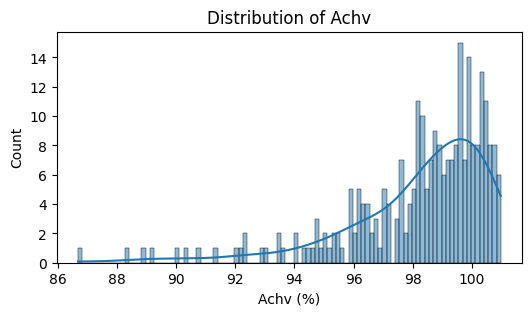

Achv Box-Cox Lambda: 26.515449043261626


count    2.660000e+02
mean     2.938335e-16
std      1.001885e+00
min     -2.164901e+00
25%     -7.820019e-01
50%      3.866808e-02
75%      8.161973e-01
max      1.766812e+00
Name: Achv, dtype: float64

In [1374]:
# Visualize distribution of Achv
plt.figure(figsize=(6, 3))
sns.histplot(merged_df["Achv"], bins=100, kde=True)
plt.title("Distribution of Achv")
plt.xlabel("Achv (%)")
plt.show()

TRANSFORM_ACHV = ["box-cox", "log", "none"][0]

if TRANSFORM_ACHV == "box-cox":
    # Convert non-linear Achv score to a (almost) linear scale
    merged_df["Achv"], achv_boxcox_lambda = stats.boxcox(merged_df["Achv"])
    # Normalization
    boxcox_scaler = StandardScaler()
    merged_df["Achv"] = boxcox_scaler.fit_transform(merged_df[["Achv"]])
    print(f"Achv Box-Cox Lambda: {achv_boxcox_lambda}")
elif TRANSFORM_ACHV == "log":
    merged_df["Achv"] = np.log(merged_df["Achv"] / (101 - merged_df["Achv"]))
else:
    pass

merged_df["Achv"].describe()

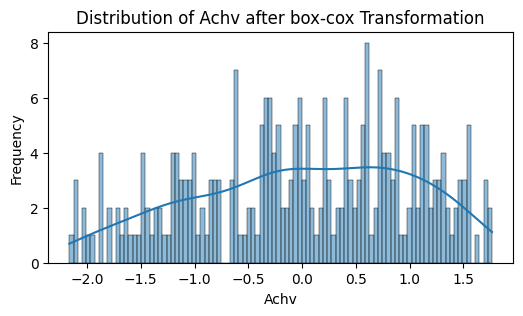

In [1375]:
plt.figure(figsize=(6, 3))
sns.histplot(merged_df["Achv"], bins=100, kde=True)
plt.title(f"Distribution of Achv after {TRANSFORM_ACHV} Transformation")
plt.xlabel("Achv")
plt.ylabel("Frequency")
plt.show()

In [1376]:
def Achv_inverse_transform(y_transformed):
    if TRANSFORM_ACHV == "box-cox":
        # Inverse Box-Cox transformation
        y = np.asarray(y_transformed).reshape(-1, 1)
        y = boxcox_scaler.inverse_transform(y).ravel()
        y = scipy.special.inv_boxcox(y, achv_boxcox_lambda)
    elif TRANSFORM_ACHV == "log":
        y = 101 / (1 + np.exp(-y_transformed))
    else:
        y = y_transformed
    return y

In [1377]:
# song map metrics
songs_df = Path("songs.csv")
songs_df = pd.read_csv(songs_df)
songs_df.head()

,songId,type,difficulty,noteCounts.tap,noteCounts.hold,noteCounts.slide,noteCounts.touch,noteCounts.break,noteCounts.total,noteDesigner
0,"""411Ψ892""",dx,basic,179.0,15.0,4.0,21.0,8.0,227,-
1,"""411Ψ892""",dx,advanced,298.0,31.0,12.0,31.0,10.0,382,-
2,"""411Ψ892""",dx,expert,416.0,53.0,52.0,25.0,85.0,631,ロシェ@ペンギン
3,"""411Ψ892""",dx,master,664.0,53.0,86.0,39.0,103.0,945,サファ太 vs じゃこレモン
4,#狂った民族２ PRAVARGYAZOOQA,dx,basic,172.0,10.0,10.0,8.0,44.0,244,-


In [1378]:
songs_df["songId"] = songs_df["songId"].str.replace('"', "")

merged_df.rename(columns={"Chart": "type", "Difficulty": "difficulty"}, inplace=True)
merged_df["type"] = merged_df["type"].str.lower()
merged_df["difficulty"] = merged_df["difficulty"].str.lower()

merged_df = merged_df.merge(
    songs_df, on=["songId", "type", "difficulty"], how="left", copy=False
)

In [1379]:
# Check new dataset for missing values
print(f"\nTotal rows with missing values: {merged_df.isna().any(axis=1).sum()}")
print("Rows with missing values:")
merged_df[merged_df.isna().any(axis=1)]


Total rows with missing values: 91
Rows with missing values:


,songId,Genre,Version,type,difficulty,Level,Achv,Rank,DX Score,Chart Constant,bpm,releaseDate,noteCounts.tap,noteCounts.hold,noteCounts.slide,noteCounts.touch,noteCounts.break,noteCounts.total,noteDesigner
3,Hand in Hand,niconico＆VOCALOID™,PiNK PLUS,std,expert,10,-1.110576,AAA,1233,10.5,128.0,1512.0,336.0,20.0,44.0,NaN,11.0,411.0,Revo@LC
10,Glorious Crown,maimai,PiNK,std,advanced,10,1.057664,SSS,1851,10.5,225.0,1415.0,572.0,14.0,19.0,NaN,12.0,617.0,-
23,ネ！コ！,POPS＆ANIME,FiNALE,std,expert,10+,1.199914,SSS,1221,10.6,182.0,2346.0,294.0,55.0,32.0,NaN,26.0,407.0,玉子豆腐
24,Bad Apple!! feat.nomico,東方Project,GreeN,std,expert,10+,0.406118,SS,1344,10.6,138.0,365.0,376.0,47.0,17.0,NaN,8.0,448.0,譜面-100号
25,the EmpErroR,maimai,FiNALE,std,advanced,10+,-0.336561,S+,1599,10.6,240.0,2494.0,476.0,35.0,18.0,NaN,4.0,533.0,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,エイリアンエイリアン,niconico＆VOCALOID™,MURASAKi PLUS,std,master,12+,-1.132061,AAA,2268,12.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
253,FREEDOM DiVE (tpz Overcute Remix),GAME＆VARIETY,MiLK PLUS,std,expert,12+,1.014386,SSS,2103,12.8,234.0,2297.0,509.0,85.0,39.0,NaN,68.0,701.0,華火職人
256,シャルル,niconico＆VOCALOID™,MiLK,std,master,12+,-1.389678,AAA,1767,12.9,145.0,2155.0,445.0,36.0,69.0,NaN,39.0,589.0,すきやき奉行
258,VIIIbit Explorer,maimai,FESTiVAL,std,expert,12+,-1.072804,AAA,1968,12.9,188.0,3297.0,472.0,67.0,72.0,NaN,45.0,656.0,翠楼屋


In [1380]:
note_count_columns = [
    "noteCounts.tap",
    "noteCounts.hold",
    "noteCounts.touch",
    "noteCounts.break",
]

for column in note_count_columns:
    # Fill missing noteCounts value with median of the same Level
    median_values = merged_df.groupby("Level")[column].median()
    merged_df.fillna({column: merged_df["Level"].map(median_values)}, inplace=True)

# Scale to match DX Score calculation
total_notes = merged_df[note_count_columns].sum(axis=1)
merged_df["noteCounts.total"] = merged_df["DX Score"] / 3
merged_df[note_count_columns] = (
    merged_df[note_count_columns]
    .multiply(merged_df["noteCounts.total"] / total_notes, axis=0)
    .round()
)

print(
    f"\nRemaining missing noteCounts values:\n{merged_df[note_count_columns].isna().sum()}"
)
merged_df[merged_df[note_count_columns].isna().any(axis=1)]


Remaining missing noteCounts values:
noteCounts.tap      0
noteCounts.hold     0
noteCounts.touch    0
noteCounts.break    0
dtype: int64


,songId,Genre,Version,type,difficulty,Level,Achv,Rank,DX Score,Chart Constant,bpm,releaseDate,noteCounts.tap,noteCounts.hold,noteCounts.slide,noteCounts.touch,noteCounts.break,noteCounts.total,noteDesigner


In [1381]:
# Check new dataset for missing values
print(f"\nTotal rows with missing values: {merged_df.isna().any(axis=1).sum()}")
print("Rows with missing values:")
# Hide cols with no missing values
merged_df[merged_df.isna().any(axis=1)]


Total rows with missing values: 23
Rows with missing values:


,songId,Genre,Version,type,difficulty,Level,Achv,Rank,DX Score,Chart Constant,bpm,releaseDate,noteCounts.tap,noteCounts.hold,noteCounts.slide,noteCounts.touch,noteCounts.break,noteCounts.total,noteDesigner
26,檄！帝国華撃団(改),GAME＆VARIETY,maimai,std,master,10+,-1.197045,AAA,705,10.7,144.0,0.0,184.0,25.0,NaN,12.0,13.0,235.0,NaN
43,偉大なる悪魔は実は大天使パトラちゃん様なのだ！,POPS＆ANIME,BUDDiES PLUS,dx,expert,10+,1.434087,SSS+,1728,10.7,195.0,4419.0,452.0,61.0,NaN,30.0,33.0,576.0,NaN
57,木彫り鯰と右肩ゾンビ,niconico＆VOCALOID™,PiNK PLUS,std,expert,10+,-0.137419,S+,1632,10.8,150.0,1590.0,427.0,58.0,NaN,29.0,31.0,544.0,NaN
60,ヒトガタ,POPS＆ANIME,UNiVERSE PLUS,dx,expert,10+,0.687325,SS+,1650,10.8,NaN,NaN,431.0,58.0,NaN,29.0,31.0,550.0,NaN
64,人マニア,niconico＆VOCALOID™,PRiSM (beta),dx,expert,10+,0.734280,SS+,1260,10.9,150.0,4461.0,329.0,44.0,NaN,22.0,24.0,420.0,NaN
68,弱虫モンブラン,niconico＆VOCALOID™,GreeN,std,expert,10+,0.963174,SSS,801,10.9,120.0,547.0,209.0,28.0,NaN,14.0,15.0,267.0,NaN
74,Ultimate taste,東方Project,PRiSM (beta),dx,expert,11,0.838520,SS+,1785,11.0,NaN,NaN,474.0,67.0,NaN,24.0,30.0,595.0,NaN
75,分解収束テイル,maimai,FESTiVAL,dx,expert,11,1.040287,SSS,2007,11.0,NaN,NaN,532.0,76.0,NaN,27.0,34.0,669.0,NaN
82,蒼空に舞え、墨染の桜,東方Project,PiNK,std,expert,11,0.822257,SS+,1551,11.0,150.0,1401.0,411.0,58.0,NaN,21.0,26.0,517.0,NaN
85,天ノ弱,niconico＆VOCALOID™,GreeN,std,expert,11,0.798018,SS+,1251,11.0,200.0,561.0,332.0,47.0,NaN,17.0,21.0,417.0,NaN


In [1382]:
# SongId specific feature engineering
# * Length of songId
# * language classifier (English/Japanese)
# * HasPunctuation
merged_df["songId_length"] = merged_df["songId"].str.strip().str.len()
merged_df["songId_English"] = (
    merged_df["songId"].str.count(r"[A-Za-z0-9]").fillna(0).astype(int)
)
merged_df["songId_Japanese"] = (
    merged_df["songId"]
    .str.count(r"[\u3040-\u309F\u30A0-\u30FF\u4E00-\u9FFF\uFF65-\uFF9F]")
    .fillna(0)
    .astype(int)
)
merged_df["songId_Punctuation"] = (
    merged_df["songId"].str.count(r"[^\w\s]").fillna(0).astype(int)
)
merged_df.columns

Index(['songId', 'Genre', 'Version', 'type', 'difficulty', 'Level', 'Achv',
       'Rank', 'DX Score', 'Chart Constant', 'bpm', 'releaseDate',
       'noteCounts.tap', 'noteCounts.hold', 'noteCounts.slide',
       'noteCounts.touch', 'noteCounts.break', 'noteCounts.total',
       'noteDesigner', 'songId_length', 'songId_English', 'songId_Japanese',
       'songId_Punctuation'],
      dtype='object')

In [1383]:
# Unique versions
print(merged_df["Version"].unique())
# Sort versions properly
versions = [
    "maimai",
    "maimai PLUS",
    "GreeN",
    "GreeN PLUS",
    "ORANGE",
    "ORANGE PLUS",
    "PiNK",
    "PiNK PLUS",
    "MURASAKi",
    "MURASAKi PLUS",
    "MiLK",
    "MiLK PLUS",
    "FiNALE",
    "maimaiでらっくす",
    "maimaiでらっくす PLUS",
    "Splash",
    "Splash PLUS",
    "UNiVERSE",
    "UNiVERSE PLUS",
    "FESTiVAL",
    "FESTiVAL PLUS",
    "BUDDiES",
    "BUDDiES PLUS",
    "PRiSM (beta)",
    "PRiSM PLUS (beta)",
]
version_order = {version: i + 1 for i, version in enumerate(versions)}

merged_df["Version"] = merged_df["Version"].map(version_order)
merged_df["Version"]

['PRiSM (beta)' 'PRiSM PLUS (beta)' 'PiNK PLUS' 'UNiVERSE PLUS'
 'maimaiでらっくす' 'FESTiVAL PLUS' 'BUDDiES' 'Splash' 'PiNK' 'UNiVERSE'
 'FESTiVAL' 'BUDDiES PLUS' 'FiNALE' 'GreeN' 'maimai' 'GreeN PLUS'
 'ORANGE PLUS' 'MiLK' 'MURASAKi' 'Splash PLUS' 'maimai PLUS' 'MiLK PLUS'
 'MURASAKi PLUS' 'maimaiでらっくす PLUS' 'ORANGE']


0      24
1      24
2      25
3       8
4      19
       ..
261    24
262    24
263    20
264    20
265    20
Name: Version, Length: 266, dtype: int64

In [1384]:
# Convert "type" into simple numeric categories
type_mapping = {"std": 0, "dx": 1}
merged_df["type"] = merged_df["type"].map(type_mapping)
merged_df.head(3)

,songId,Genre,Version,type,difficulty,Level,Achv,Rank,DX Score,Chart Constant,bpm,releaseDate,noteCounts.tap,noteCounts.hold,noteCounts.slide,noteCounts.touch,noteCounts.break,noteCounts.total,noteDesigner,songId_length,songId_English,songId_Japanese,songId_Punctuation
0,バベル,niconico＆VOCALOID™,24,1,expert,10,-0.776047,S,1464,10.5,225.0,4531.0,385.0,68.0,43.0,20.0,15.0,488.0,アマリリス,3,0,3,0
1,てらてら,niconico＆VOCALOID™,24,1,expert,10,-0.934317,AAA,1584,10.5,190.0,4517.0,407.0,44.0,33.0,15.0,62.0,528.0,みそかつ侍,4,0,4,0
2,メズマライザー,niconico＆VOCALOID™,25,1,expert,10,1.443766,SSS+,1572,10.5,185.0,4628.0,424.0,49.0,56.0,32.0,18.0,524.0,ロシェ@ペンギン,7,0,7,0


In [1385]:
# Convert "difficulty" into simple numeric categories
difficulty_mapping = {
    "basic": 0,
    "advanced": 1,
    "expert": 2,
    "master": 3,
    "re:master": 4,
}
merged_df["difficulty"] = merged_df["difficulty"].map(difficulty_mapping)
merged_df.head(3)

,songId,Genre,Version,type,difficulty,Level,Achv,Rank,DX Score,Chart Constant,bpm,releaseDate,noteCounts.tap,noteCounts.hold,noteCounts.slide,noteCounts.touch,noteCounts.break,noteCounts.total,noteDesigner,songId_length,songId_English,songId_Japanese,songId_Punctuation
0,バベル,niconico＆VOCALOID™,24,1,2,10,-0.776047,S,1464,10.5,225.0,4531.0,385.0,68.0,43.0,20.0,15.0,488.0,アマリリス,3,0,3,0
1,てらてら,niconico＆VOCALOID™,24,1,2,10,-0.934317,AAA,1584,10.5,190.0,4517.0,407.0,44.0,33.0,15.0,62.0,528.0,みそかつ侍,4,0,4,0
2,メズマライザー,niconico＆VOCALOID™,25,1,2,10,1.443766,SSS+,1572,10.5,185.0,4628.0,424.0,49.0,56.0,32.0,18.0,524.0,ロシェ@ペンギン,7,0,7,0


In [1386]:
merged_df.describe(include="all")

,songId,Genre,Version,type,difficulty,Level,Achv,Rank,DX Score,Chart Constant,bpm,releaseDate,noteCounts.tap,noteCounts.hold,noteCounts.slide,noteCounts.touch,noteCounts.break,noteCounts.total,noteDesigner,songId_length,songId_English,songId_Japanese,songId_Punctuation
count,266,266,266.000000,266.000000,266.000000,266,2.660000e+02,266,266.000000,266.000000,261.000000,261.000000,266.000000,266.000000,244.000000,266.000000,266.000000,266.000000,244,266.000000,266.000000,266.000000,266.000000
unique,253,6,NaN,NaN,NaN,7,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36,NaN,NaN,NaN,NaN
top,メズマライザー,maimai,NaN,NaN,NaN,11+,NaN,S+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,はっぴー,NaN,NaN,NaN,NaN
freq,2,75,NaN,NaN,NaN,64,NaN,54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35,NaN,NaN,NaN,NaN
mean,NaN,NaN,17.503759,0.710526,2.195489,NaN,2.938335e-16,NaN,1701.033835,11.580451,174.528736,3243.597701,434.631579,64.537594,51.053279,33.695489,34.135338,567.011278,NaN,10.883459,5.650376,4.191729,0.533835
std,NaN,NaN,6.564771,0.454373,0.442269,NaN,1.001885e+00,NaN,333.083415,0.729689,33.328264,1286.338974,97.013749,27.120425,27.489639,21.674116,27.703356,111.027805,NaN,6.444945,6.668565,4.944683,1.149562
min,NaN,NaN,1.000000,0.000000,1.000000,NaN,-2.164901e+00,NaN,690.000000,10.500000,70.000000,0.000000,133.000000,0.000000,4.000000,0.000000,2.000000,230.000000,NaN,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,13.000000,0.000000,2.000000,NaN,-7.820019e-01,NaN,1488.750000,10.900000,150.000000,2351.000000,374.000000,46.000000,33.000000,21.000000,16.250000,496.250000,NaN,6.250000,0.000000,0.000000,0.000000
50%,NaN,NaN,20.000000,1.000000,2.000000,NaN,3.866808e-02,NaN,1689.000000,11.700000,175.000000,3705.000000,436.500000,62.000000,47.000000,27.000000,27.000000,563.000000,NaN,10.000000,0.000000,3.000000,0.000000
75%,NaN,NaN,23.000000,1.000000,2.000000,NaN,8.161973e-01,NaN,1947.000000,12.000000,195.000000,4293.000000,503.750000,79.000000,65.000000,43.000000,41.750000,649.000000,NaN,14.000000,11.000000,8.000000,1.000000


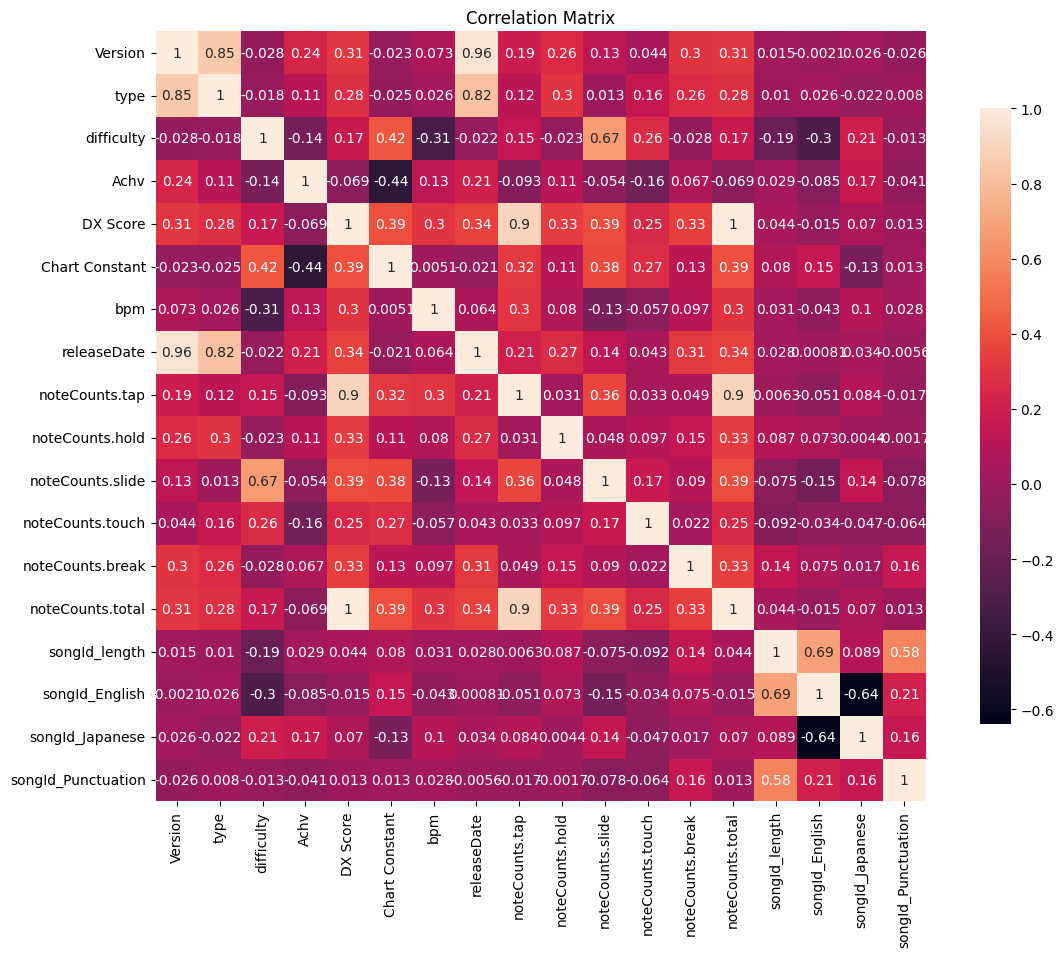

In [1387]:
# Filter out numerical columns for correlation matrix
correlation_matrix = merged_df.select_dtypes(include=["number"]).corr()

fig = plt.figure(clear=True, figsize=(14, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    square=True,
    cbar_kws={"shrink": 0.8},
)
plt.title("Correlation Matrix")
plt.show()

In [1388]:
def correlation_rankings(
    corr_mat: pd.DataFrame, target_column: str, threshold: float = 0.6
):
    """Print all abs(correlation with anything) that exceeds a threshold"""
    output = []

    for col in corr_mat.columns:
        if col == target_column:
            continue

        strong_correlations = (
            corr_mat[col][corr_mat[col].abs() > threshold]
            .drop(col)
            .sort_values(ascending=False, key=lambda x: x.abs())
        )

        if not strong_correlations.empty:
            formatted_corrs: list = []
            for corr_col, value in strong_correlations.items():
                color: str = "bold green" if value > 0 else "bold red"
                formatted_corrs.append(f"[{color}]{corr_col} ({value:.2f})[/{color}]")

            corr_with_target = corr_mat.loc[col, target_column]
            correlations_str = ", ".join(formatted_corrs)

            header = "".join(
                [
                    f"[bold sky_blue1]{col} ({target_column}: {corr_with_target:.2f}, ",
                    f"count: {len(strong_correlations)}):[/bold sky_blue1]",
                ]
            )
            full_line = f"{header} [{correlations_str}]"

            output.append(full_line)

    output.sort(
        key=lambda x: float(x.split(f"({target_column}: ")[1].split(",")[0]),
        reverse=True,
    )
    if output:
        rich.print("\n".join(output))


correlation_rankings(correlation_matrix, target_column="Achv")

Version (Achv: 0.24, count: 2): [releaseDate (0.96), type (0.85)]
releaseDate (Achv: 0.21, count: 2): [Version (0.96), type (0.82)]
songId_Japanese (Achv: 0.17, count: 1): [songId_English (-0.64)]
type (Achv: 0.11, count: 2): [Version (0.85), releaseDate (0.82)]
songId_length (Achv: 0.03, count: 1): [songId_English (0.69)]
noteCounts.slide (Achv: -0.05, count: 1): [difficulty (0.67)]
DX Score (Achv: -0.07, count: 2): [noteCounts.total (1.00), noteCounts.tap (0.90)]
noteCounts.total (Achv: -0.07, count: 2): [DX Score (1.00), noteCounts.tap (0.90)]
songId_English (Achv: -0.08, count: 2): [songId_length (0.69), songId_Japanese (-0.64)]
noteCounts.tap (Achv: -0.09, count: 2): [DX Score (0.90), noteCounts.total (0.90)]
difficulty (Achv: -0.14, count: 1): [noteCounts.slide (0.67)]

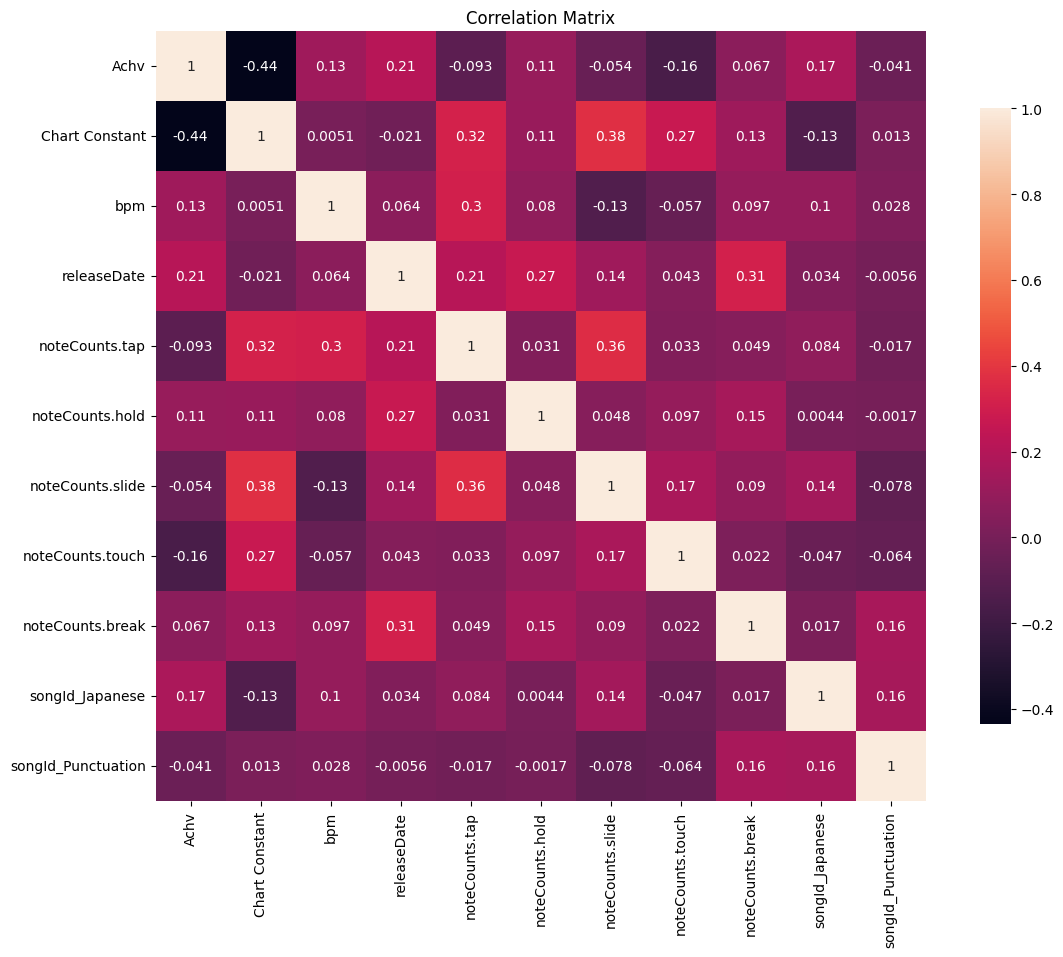

In [1389]:
# Drop collinear columns
merged_df.drop(
    columns=[
        "DX Score",
        "Version",
        "noteCounts.total",
        "type",
        "songId_English",
        "difficulty",
        "songId_length",
    ],
    inplace=True,
)

correlation_matrix = merged_df.select_dtypes(include=["number"]).corr()
correlation_rankings(correlation_matrix, target_column="Achv")

fig = plt.figure(clear=True, figsize=(14, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    square=True,
    cbar_kws={"shrink": 0.8},
)
plt.title("Correlation Matrix")
plt.show()

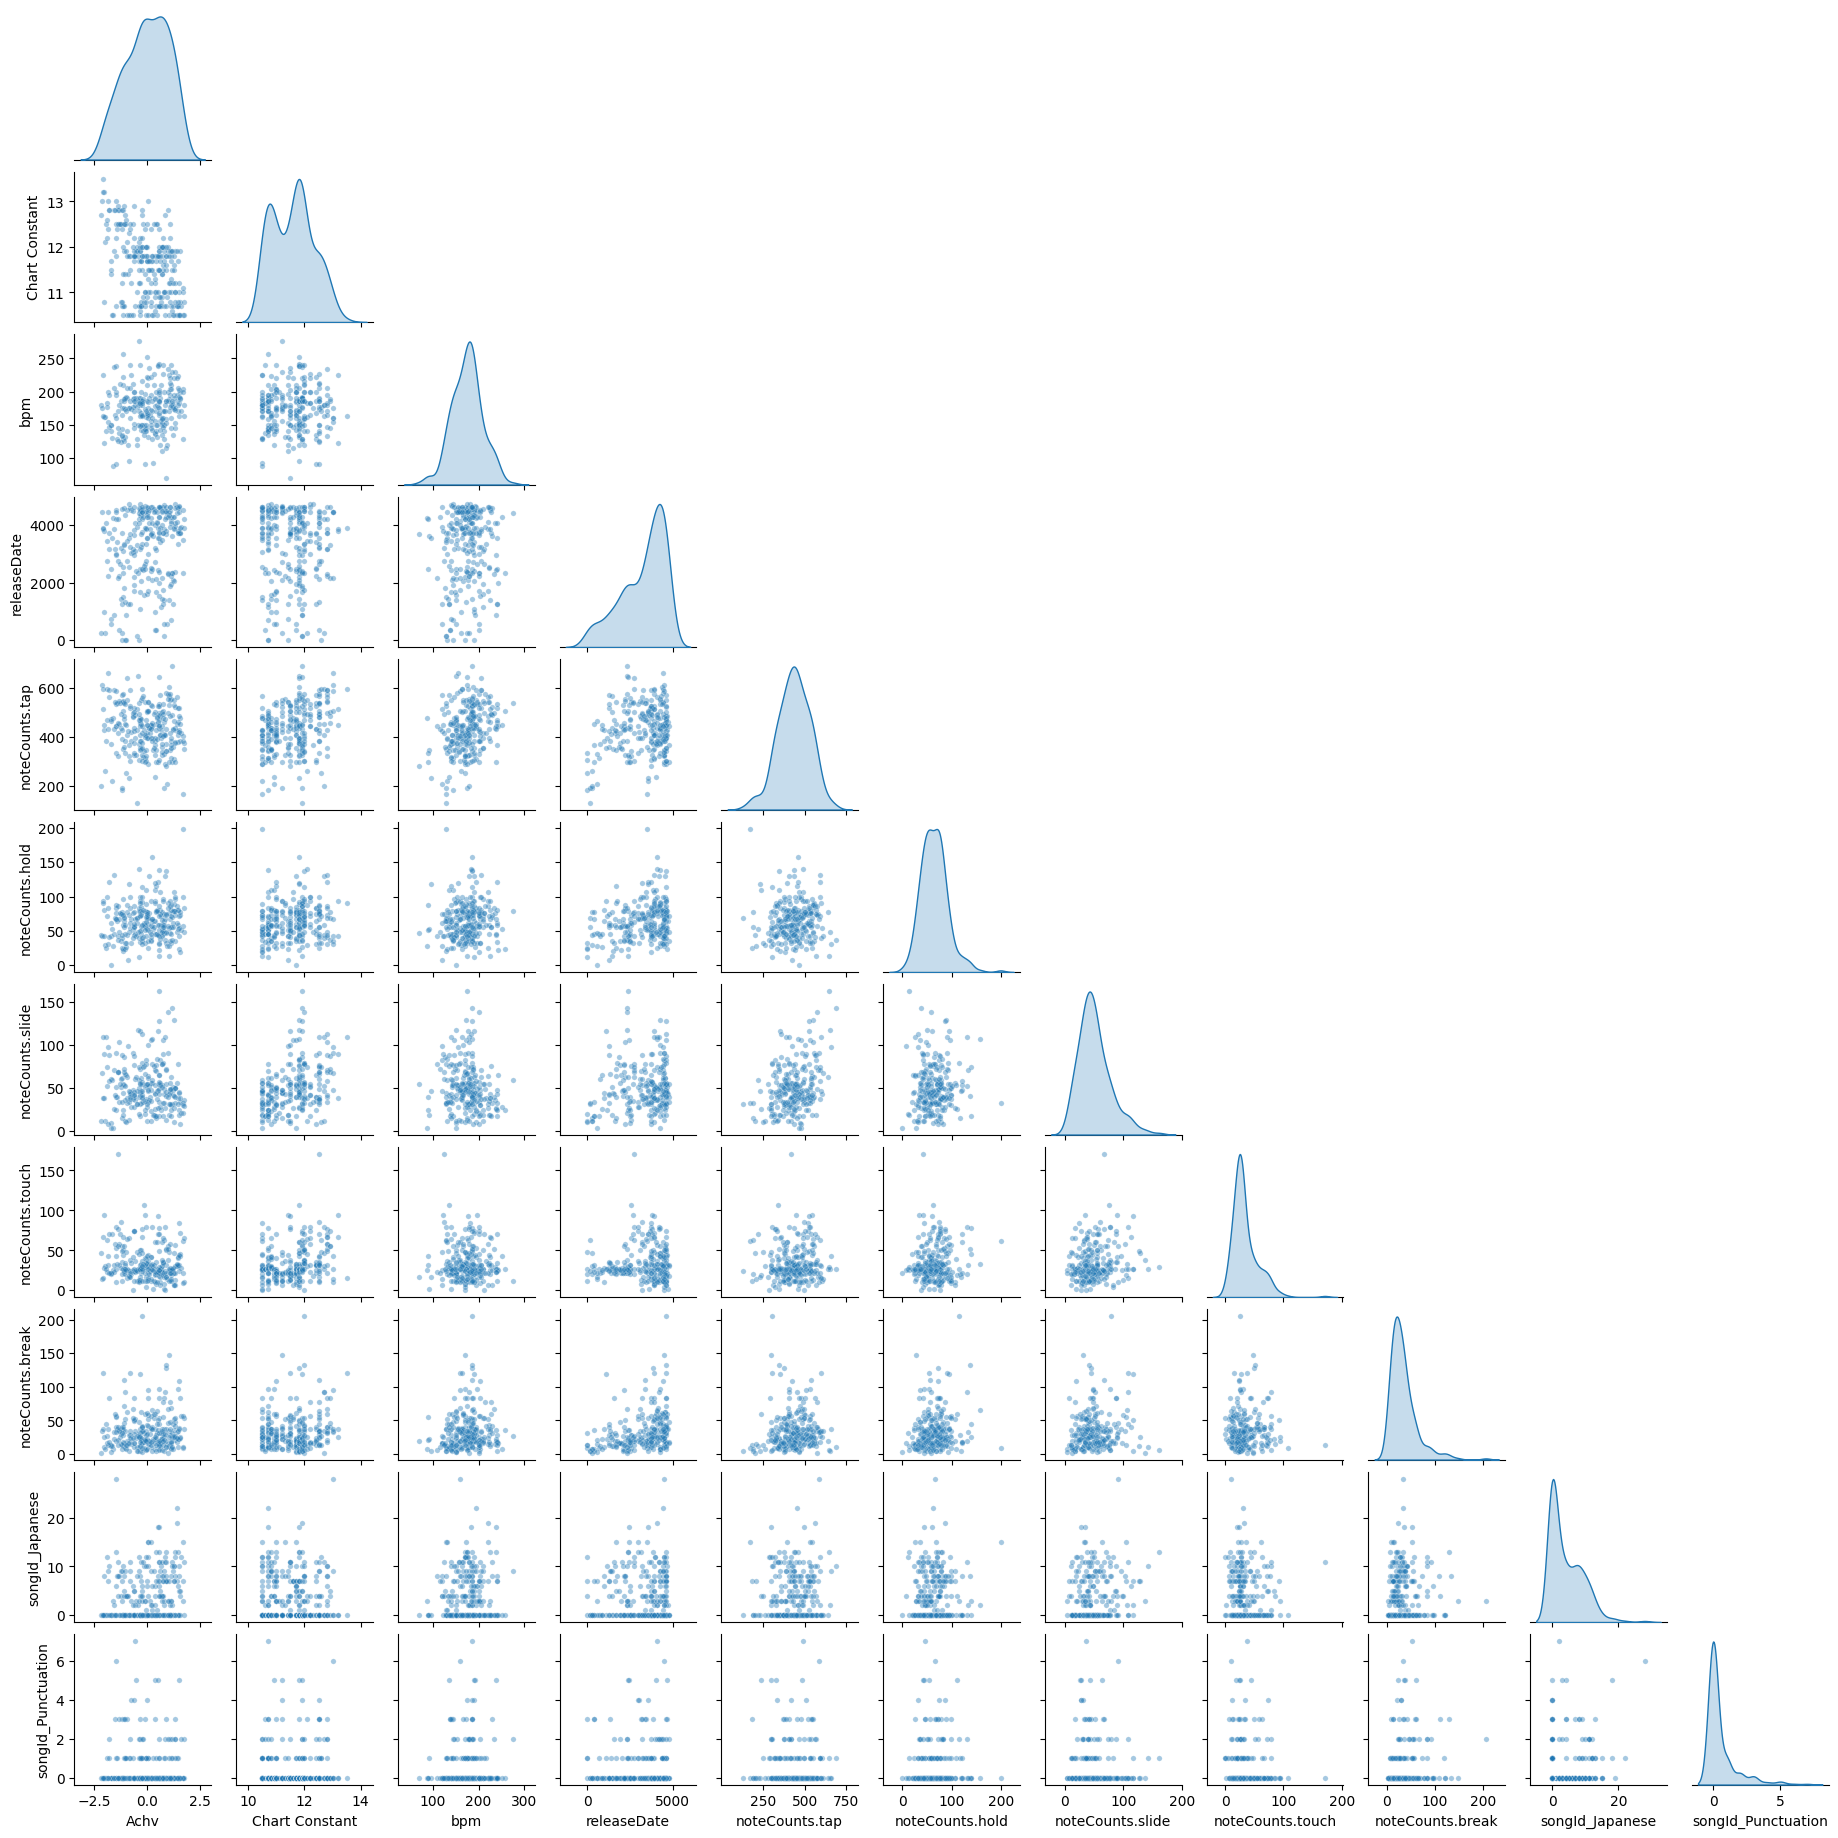

In [1390]:
# Pairwise correlation with seaborn
sns.pairplot(
    merged_df,
    diag_kind="kde",
    plot_kws={"alpha": 0.4, "s": 15},
    corner=True,
    height=1.7,
)
plt.show()

Regression

In [1391]:
print(merged_df.columns)

numerical_features = (
    merged_df.select_dtypes(include=["number"]).columns.drop("Achv").tolist()
)
categorical_features = ["Genre"]

# Ignore NaN in unused features
merged_df.drop(
    columns=[
        feature
        for feature in merged_df.columns
        if feature not in numerical_features + categorical_features + ["Achv", "Rank"]
    ],
    inplace=True,
)

print("Dropping ", merged_df.isna().any(axis=1).sum(), "NaN rows")
merged_df.dropna(inplace=True)

Index(['songId', 'Genre', 'Level', 'Achv', 'Rank', 'Chart Constant', 'bpm',
       'releaseDate', 'noteCounts.tap', 'noteCounts.hold', 'noteCounts.slide',
       'noteCounts.touch', 'noteCounts.break', 'noteDesigner',
       'songId_Japanese', 'songId_Punctuation'],
      dtype='object')
Dropping  23 NaN rows


In [1392]:
# merged_df.to_csv("maimai_cleaned.csv", index=False)

In [1393]:
preprocessor_linreg = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline(
                steps=[
                    (
                        "poly",
                        PolynomialFeatures(
                            degree=2, include_bias=False, interaction_only=False
                        ),
                    ),
                    ("scaler", RobustScaler()),
                ]
            ),
            numerical_features,
        ),
        (
            "cat",
            OneHotEncoder(
                sparse_output=False,
                handle_unknown="error",
                categories=[
                    merged_df[column].unique().tolist()
                    for column in categorical_features
                ],
            ),
            categorical_features,
        ),
    ]
)
pipeline_linreg = Pipeline(
    steps=[
        ("preprocessor_linreg", preprocessor_linreg),
        (
            "feature_selector",
            SelectFromModel(
                ElasticNetCV(
                    max_iter=10000,
                    l1_ratio=[0.1, 0.25, 0.5, 0.75, 0.8, 0.85, 0.9, 0.99],
                    random_state=RANDOM_STATE,
                )
            ),
        ),
        ("regressor", RidgeCV(alphas=np.logspace(-3, 3, 20))),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    merged_df[numerical_features + categorical_features],
    merged_df["Achv"],
    random_state=RANDOM_STATE,
    test_size=0.2,
    shuffle=True,
    stratify=merged_df["Rank"],
)

pipeline_linreg.fit(X_train, y_train)
chosen_alpha = pipeline_linreg.named_steps["regressor"].alpha_
print("Chosen alpha:", chosen_alpha)

y_train_pred = pipeline_linreg.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_absolute_error(y_train, y_train_pred)
print("Train set performance:")
print(f"R^2 Score: {train_r2:.4f}")
print(f"Mean Absolute Error: {train_mse:.4f}")

y_test_pred = pipeline_linreg.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_absolute_error(y_test, y_test_pred)
print("Test set performance:")
print(f"R^2 Score: {test_r2:.4f}")
print(f"Mean Absolute Error: {test_mse:.4f}")

cat_encoder = pipeline_linreg.named_steps["preprocessor_linreg"].named_transformers_[
    "cat"
]
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)

all_feature_names = (
    list(cat_feature_names)
    + pipeline_linreg.named_steps["preprocessor_linreg"]
    .named_transformers_["num"]
    .named_steps["poly"]
    .get_feature_names_out(numerical_features)
    .tolist()
)

selector_step = pipeline_linreg.named_steps["feature_selector"]
selected_mask = selector_step.get_support()

regressor_step = pipeline_linreg.named_steps["regressor"]

results_df = pd.DataFrame(
    {
        "Feature": [
            all_feature_names[i]
            for i in range(len(all_feature_names))
            if selected_mask[i]
        ],
        "Coefficient": regressor_step.coef_,
    }
).sort_values(by="Coefficient", ascending=False)
print(results_df)

Chosen alpha: 6.158482110660261
Train set performance:
R^2 Score: 0.2691
Mean Absolute Error: 0.7141
Test set performance:
R^2 Score: 0.3053
Mean Absolute Error: 0.6877
                               Feature  Coefficient
1      Chart Constant noteCounts.slide     0.326873
3       noteCounts.tap songId_Japanese     0.146245
2      noteCounts.tap noteCounts.break     0.057077
5  noteCounts.slide songId_Punctuation    -0.023457
4   noteCounts.hold songId_Punctuation    -0.032496
0                      noteCounts.hold    -0.590089


d:\Personal Data\Repositories\personal-repo\maimai-dx-regression\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.561e-02, tolerance: 1.550e-02
  model = cd_fast.enet_coordinate_descent_gram(
d:\Personal Data\Repositories\personal-repo\maimai-dx-regression\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.938e-02, tolerance: 1.550e-02
  model = cd_fast.enet_coordinate_descent_gram(
d:\Personal Data\Repositories\personal-repo\maimai-dx-regression\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You migh

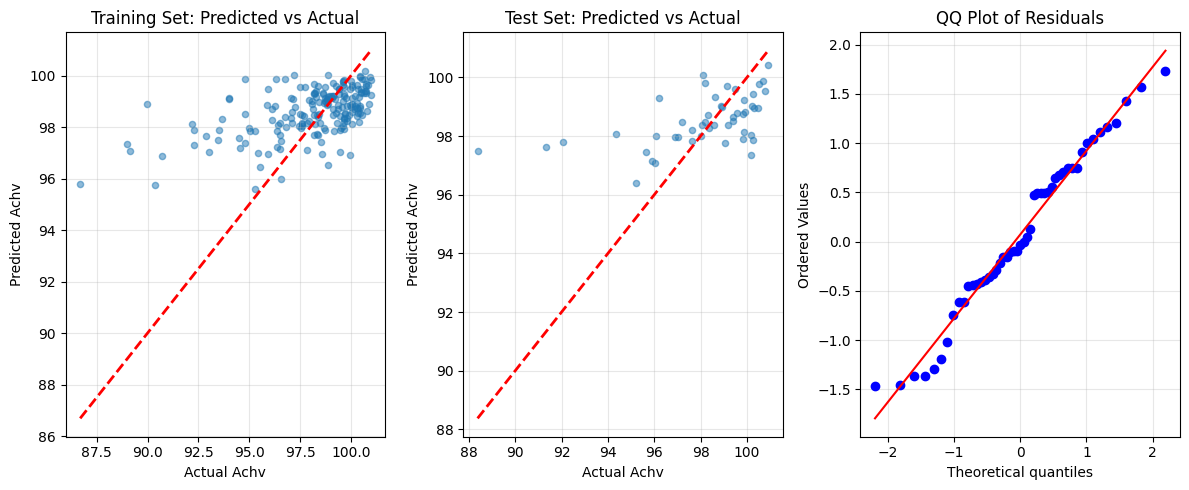

In [1394]:
y_train_inv = Achv_inverse_transform(y_train)
y_train_pred_inv = Achv_inverse_transform(y_train_pred)
y_test_inv = Achv_inverse_transform(y_test)
y_test_pred_inv = Achv_inverse_transform(y_test_pred)

fig, axes = plt.subplots(1, 3, figsize=(12, 5))
# 1. Predicted vs Actual for training set
axes[0].scatter(y_train_inv, y_train_pred_inv, alpha=0.5, s=20)
axes[0].plot(
    [y_train_inv.min(), y_train_inv.max()],
    [y_train_inv.min(), y_train_inv.max()],
    "r--",
    lw=2,
)
axes[0].set_xlabel("Actual Achv")
axes[0].set_ylabel("Predicted Achv")
axes[0].set_title("Training Set: Predicted vs Actual")
axes[0].grid(True, alpha=0.3)

# 2. Predicted vs Actual for test set
axes[1].scatter(y_test_inv, y_test_pred_inv, alpha=0.5, s=20)
axes[1].plot(
    [y_test_inv.min(), y_test_inv.max()],
    [y_test_inv.min(), y_test_inv.max()],
    "r--",
    lw=2,
)
axes[1].set_xlabel("Actual Achv")
axes[1].set_ylabel("Predicted Achv")
axes[1].set_title("Test Set: Predicted vs Actual")
axes[1].grid(True, alpha=0.3)

# 3. Residual QQ plot
residuals = y_test - y_test_pred
stats.probplot(residuals, dist="norm", plot=axes[2])
axes[2].set_title("QQ Plot of Residuals")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [1395]:
preprocessor_rf = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        (
            "cat",
            OneHotEncoder(
                sparse_output=False,
                handle_unknown="error",
                categories=[
                    merged_df[column].unique().tolist()
                    for column in categorical_features
                ],
            ),
            categorical_features,
        ),
    ]
)
pipeline_rf = Pipeline(
    steps=[
        ("preprocessor_linreg", preprocessor_rf),
        (
            "rfr",
            RandomForestRegressor(
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)
param_grid = {
    "rfr__n_estimators": np.arange(1, 201, 1),
    "rfr__max_depth": np.arange(2, 6, 1),
    "rfr__min_samples_leaf": np.arange(1, 8, 1),
    "rfr__ccp_alpha": np.arange(0, 0.04, 0.001),
}

grid_search = RandomizedSearchCV(
    pipeline_rf,
    param_grid,
    scoring="r2",
    # n_jobs=4,
    verbose=10,
    random_state=RANDOM_STATE,
    n_iter=100,
)

grid_search.fit(X_train, y_train)
pipeline_rf = grid_search.best_estimator_
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV MAE: {-grid_search.best_score_:.4f}")

y_train_pred_rf = pipeline_rf.predict(X_train)
train_r2_rf = r2_score(y_train, y_train_pred_rf)
train_mse_rf = mean_absolute_error(y_train, y_train_pred_rf)
print("Train set performance:")
print(f"R^2 Score: {train_r2_rf:.4f}")
print(f"Mean Absolute Error: {train_mse_rf:.4f}")

y_test_pred_rf = pipeline_rf.predict(X_test)
test_r2_rf = r2_score(y_test, y_test_pred_rf)
test_mse_rf = mean_absolute_error(y_test, y_test_pred_rf)
print("Test set performance:")
print(f"R^2 Score: {test_r2_rf:.4f}")
print(f"Mean Absolute Error: {test_mse_rf:.4f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5; 1/100] START rfr__ccp_alpha=0.018000000000000002, rfr__max_depth=5, rfr__min_samples_leaf=5, rfr__n_estimators=59
[CV 1/5; 1/100] END rfr__ccp_alpha=0.018000000000000002, rfr__max_depth=5, rfr__min_samples_leaf=5, rfr__n_estimators=59;, score=-0.220 total time=   0.0s
[CV 2/5; 1/100] START rfr__ccp_alpha=0.018000000000000002, rfr__max_depth=5, rfr__min_samples_leaf=5, rfr__n_estimators=59
[CV 2/5; 1/100] END rfr__ccp_alpha=0.018000000000000002, rfr__max_depth=5, rfr__min_samples_leaf=5, rfr__n_estimators=59;, score=0.356 total time=   0.0s
[CV 3/5; 1/100] START rfr__ccp_alpha=0.018000000000000002, rfr__max_depth=5, rfr__min_samples_leaf=5, rfr__n_estimators=59
[CV 3/5; 1/100] END rfr__ccp_alpha=0.018000000000000002, rfr__max_depth=5, rfr__min_samples_leaf=5, rfr__n_estimators=59;, score=0.089 total time=   0.0s
[CV 4/5; 1/100] START rfr__ccp_alpha=0.018000000000000002, rfr__max_depth=5, rfr__min_samples_leaf=5, rfr

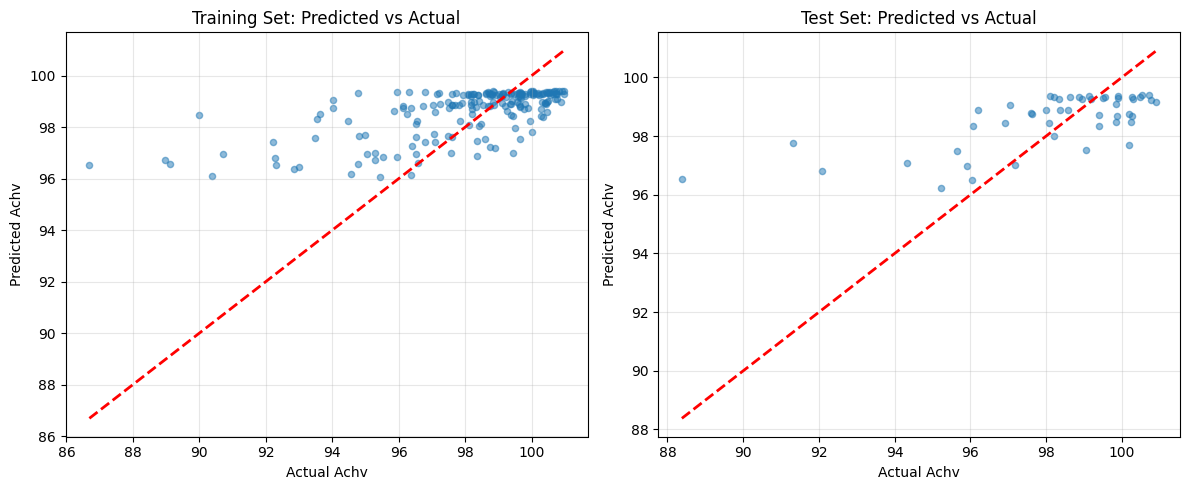

In [1396]:
y_train_inv_rf = Achv_inverse_transform(y_train)
y_train_pred_inv_rf = Achv_inverse_transform(y_train_pred_rf)
y_test_inv_rf = Achv_inverse_transform(y_test)
y_test_pred_inv_rf = Achv_inverse_transform(y_test_pred_rf)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# 1. Predicted vs Actual for training set
axes[0].scatter(y_train_inv_rf, y_train_pred_inv_rf, alpha=0.5, s=20)
axes[0].plot(
    [y_train_inv_rf.min(), y_train_inv_rf.max()],
    [y_train_inv_rf.min(), y_train_inv_rf.max()],
    "r--",
    lw=2,
)
axes[0].set_xlabel("Actual Achv")
axes[0].set_ylabel("Predicted Achv")
axes[0].set_title("Training Set: Predicted vs Actual")
axes[0].grid(True, alpha=0.3)

# 2. Predicted vs Actual for test set
axes[1].scatter(y_test_inv_rf, y_test_pred_inv_rf, alpha=0.5, s=20)
axes[1].plot(
    [y_test_inv_rf.min(), y_test_inv_rf.max()],
    [y_test_inv_rf.min(), y_test_inv_rf.max()],
    "r--",
    lw=2,
)
axes[1].set_xlabel("Actual Achv")
axes[1].set_ylabel("Predicted Achv")
axes[1].set_title("Test Set: Predicted vs Actual")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

               Feature  Importance
0       Chart Constant    0.596391
2          releaseDate    0.221688
5     noteCounts.slide    0.049033
1                  bpm    0.029001
15  Genre_GAME＆VARIETY    0.026060
7     noteCounts.break    0.024772
8      songId_Japanese    0.023309
3       noteCounts.tap    0.009488
4      noteCounts.hold    0.007940


C:\Users\123er\AppData\Local\Temp\ipykernel_18772\3373458492.py:29: UserWarning: Glyph 65286 (\N{FULLWIDTH AMPERSAND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\Personal Data\Repositories\personal-repo\maimai-dx-regression\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65286 (\N{FULLWIDTH AMPERSAND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


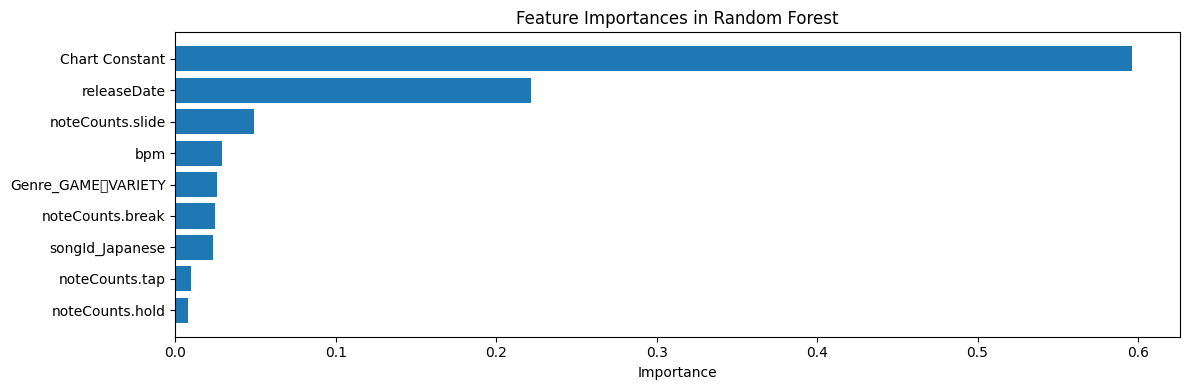

In [1397]:
rf_features_step = pipeline_rf.named_steps["preprocessor_linreg"].named_transformers_[
    "num"
]
rf_numeric_feature_names = rf_features_step.get_feature_names_out(numerical_features)

cat_encoder_rf = pipeline_rf.named_steps["preprocessor_linreg"].named_transformers_[
    "cat"
]
cat_feature_names_rf = cat_encoder.get_feature_names_out(categorical_features)

all_feature_names_rf = list(rf_numeric_feature_names) + list(cat_feature_names_rf)
rf_model = pipeline_rf.named_steps["rfr"]

importance_df = pd.DataFrame(
    {"Feature": all_feature_names_rf, "Importance": rf_model.feature_importances_}
).sort_values(by="Importance", ascending=False)
top_features = importance_df[
    importance_df["Importance"] > importance_df["Importance"].max() * 0.01
]
print(top_features)

fig, ax = plt.subplots(figsize=(12, 4))
ax.barh(range(len(top_features)), top_features["Importance"])
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features["Feature"])
ax.set_xlabel("Importance")
ax.set_title("Feature Importances in Random Forest")
ax.invert_yaxis()
plt.tight_layout()
plt.show()